In [2]:
pip install unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
from unet import UNet

In [1]:
CONFIG = {}
CONFIG['data_x_path'] = '/content/perov_5_raw_train_dist_mat.pt'
CONFIG['data_ead_path'] = '/content/perov_5_raw_train_ead_mat.pt'
CONFIG['composition_path'] = '/content/perov_5_raw_train_composition_mat.pt'
CONFIG['cell_path'] = '/content/perov_5_raw_train_cell_mat.pt'
CONFIG['data_y_path'] = "/content/targets.csv"
CONFIG['unprocessed_path'] = '/content/perov_5_raw_train_unprocessed.txt'

In [4]:
CONFIG['data_x_path']

'/content/perov_5_raw_train_dist_mat.pt'

In [5]:
unprocessed = set()
with open(CONFIG['unprocessed_path'], 'r') as f:
    for l in f.readlines():
        unprocessed.add(int(l))

In [6]:
dist_mat = torch.load(CONFIG['data_x_path'] ,map_location=torch.device('cpu')).to("cpu")
ead_mat = torch.load(CONFIG['data_ead_path'],map_location=torch.device('cpu')).to("cpu")
composition_mat = torch.load(CONFIG['composition_path'],map_location=torch.device('cpu')).to("cpu")
cell_mat = torch.load(CONFIG['cell_path'],map_location=torch.device('cpu')).to("cpu")

In [7]:
# build index
_ind = [i for i in range(dist_mat.shape[0]) if i not in unprocessed]
indices = torch.tensor(_ind, dtype=torch.long).to("cpu")

# select rows torch.Size([27136, 1])
dist_mat = dist_mat[indices] # the torch.load needs the index in tensor format to convert the loaded file in a tensor.
ead_mat = ead_mat[indices]
composition_mat = composition_mat[indices]
cell_mat = cell_mat[indices]

# normalize composition
sums = torch.sum(composition_mat, axis=1).view(-1,1)
composition_mat = composition_mat / sums
composition_mat = torch.cat((composition_mat, sums), dim=1)

y = []
with open(CONFIG['data_y_path'], 'r') as f:
    for i, d in enumerate(f.readlines()):
        if i not in unprocessed:
            y.append(float(d.split(',')[1]))

data_y = np.reshape(np.array(y), (-1,1))

data_y = torch.from_numpy(data_y)
data_y = data_y.to(torch.float32)

data_x = torch.cat((ead_mat/1000000, dist_mat, cell_mat, composition_mat, data_y), dim=1)

In [8]:
data_x.shape

torch.Size([11356, 709])

In [9]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

mask = data_x[:, 600] <= 10
data_x = data_x[mask]
#data_x, data_y = data_x[:, 0:708] , data_x[:,708]
data_x, composition_mat, data_y = data_x[:, 0:607], data_x[:,607:708] , data_x[:,708]

In [10]:
scaler = MinMaxScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)
#joblib.dump(scaler, self.CONFIG.scaler_path) # save the scaler to be used for later purpose on testing data.

comp1, comp2 = composition_mat[:, 0:100], composition_mat[:,100]/5
comp1 = (comp1.to(torch.float32))
comp2 = comp2.to(torch.float32).view(-1,1)

composition_mat_add = torch.cat((comp1,comp2), dim=1)

data_x = torch.from_numpy(data_x)
data_x = data_x.to(torch.float32)

#composition_mat = torch.from_numpy(composition_mat_add)
#composition_mat = composition_mat.to(torch.float32)

data_x = torch.cat((10*data_x,composition_mat_add), dim=1)

data_y = data_y.view(-1,1)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
data_x.shape

torch.Size([11356, 708])

In [13]:
CONFIG['seed'] = 42
CONFIG['split_ratio'] = 0.2
batch_size = 200

In [14]:
# train/test split and create torch dataloader
xtrain, xtest, ytrain, ytest = train_test_split(data_x, data_y, test_size=CONFIG['split_ratio'], random_state= CONFIG['seed'])

if not isinstance(xtrain, torch.Tensor):
    x_train = torch.tensor(xtrain, dtype=torch.float)
else:
    x_train = xtrain

if not isinstance(ytrain, torch.Tensor):
    y_train = torch.tensor(ytrain, dtype=torch.float)
else:
    y_train = ytrain

if not isinstance(xtest, torch.Tensor):
    x_test = torch.tensor(xtest, dtype=torch.float)
else:
    x_test = xtest

if not isinstance(ytest, torch.Tensor):
    y_test = torch.tensor(ytest, dtype=torch.float)
else:
    y_test = ytest


indices = ~torch.any(x_train.isnan(),dim=1)

x_train = x_train[indices]
y_train = y_train[indices] # y_train is the condition

indices = ~torch.any(x_train[:,:601] > 10 ,dim=1)
x_train = x_train[indices]
y_train = y_train[indices]

indices = ~torch.any(x_test.isnan(),dim=1)
print(indices) # tensor([True, True, True,  ..., True, True, True])

x_test = x_test[indices]
y_test = y_test[indices]
indices = ~torch.any(x_test[:,:601] > 10 ,dim=1)
x_test = x_test[indices]
y_test = y_test[indices]

train_loader = DataLoader(
    TensorDataset(x_train, y_train),
    batch_size=batch_size, shuffle=True, drop_last=False
)

test_loader = DataLoader(
    TensorDataset(x_test, y_test),
    batch_size=batch_size, shuffle=False, drop_last=False
)

tensor([True, True, True,  ..., True, True, True])


In [15]:
for test in test_loader:
  print(len(test[0]))
  print(test[0].shape)

200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
200
torch.Size([200, 708])
72
torch.Size([72, 708])


In [16]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 500):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):

        #print(x0.shape)
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """

        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs)[0] / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        result = values.gather(-1, t.cpu())

        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [17]:
diffusion_model = DiffusionModel()

In [18]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [19]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        print('Im him')

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels

        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.lin1 = nn.Linear(channels_in, channels_out)
            self.final = nn.Linear(channels_out, channels_out)
        else:
            self.lin1 = nn.Linear(2*channels_in, channels_out)
            self.final = nn.Linear(channels_out, channels_out)


        self.lin2 = nn.Linear(channels_out, channels_out)


        self.bnorm1 = nn.BatchNorm1d(channels_out)
        self.bnorm2 = nn.BatchNorm1d(channels_out)

        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):

        try:
          o = self.bnorm1(self.relu(self.lin1(x)))
        except:
          o = self.relu(self.lin1(x))

        o_time = self.relu(self.time_mlp(self.time_embedding(t)))

        o = o + o_time
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label

        try:
          o = self.bnorm2(self.relu(self.lin2(o)))
        except:
          o = self.relu(self.lin2(o))

        return self.final(o)


In [20]:
def kl_divergence(z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)

    # sum over last dim to go from single dim distribution to multi-dim
    kl = kl.sum(-1)
    return kl

In [21]:
class UNet_plus(nn.Module):
    def __init__(self, img_channels = 708, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512)):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])

        #self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.lin1 = nn.Linear(img_channels, sequence_channels[0])

        self.mu = nn.Linear(sequence_channels[0], img_channels)
        self.var = nn.Linear(sequence_channels[0], img_channels)

    def forward(self, x, t, **kwargs):

        residuals = []
        o = self.lin1(x)

        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)

        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        #self.lin2(o)

        z_mu = self.mu(o)
        z_var = self.var(o)

        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = x_sample #torch.cat((x_sample,y), dim=1)

        return z, z_mu, z_var

In [22]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

class RandomDataset(Dataset):
    def __init__(self, num_samples, vector_size):
        self.num_samples = num_samples
        self.vector_size = vector_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        #random_vector = torch.randn(self.vector_size)
        random_vector = torch.full((self.vector_size,), 1)
        return random_vector

num_samples_train = 1000
num_samples_test = 400
vector_size = 200
batch_size = 200

train_dataset = RandomDataset(num_samples_train, vector_size)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RandomDataset(num_samples_test, vector_size)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [24]:
for i in trainloader:
  print(i.shape)
  break

torch.Size([200, 200])


In [25]:
import torch

BATCH_SIZE = 200
NO_EPOCHS = 1000
PRINT_FREQUENCY = 10
LR = 0.0001
VERBOSE = True
device = 'cpu'

unet = UNet_plus(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = unet

num_params = count_parameters(model)
print("Number of parameters: {:,}".format(num_params))

Im him
Im him
Im him
Im him
Im him
Im him
Number of parameters: 1,696,456


In [167]:
for test in train_loader:
  print(len(test[0]))
  print(test[0].shape)
  print(test[0][0].shape)
  print(test[0][0][706])
  break

200
torch.Size([200, 708])
torch.Size([708])
tensor(0.)


In [168]:
train_loader

---
Epoch: 0 | Train Loss nan | Val Loss nan


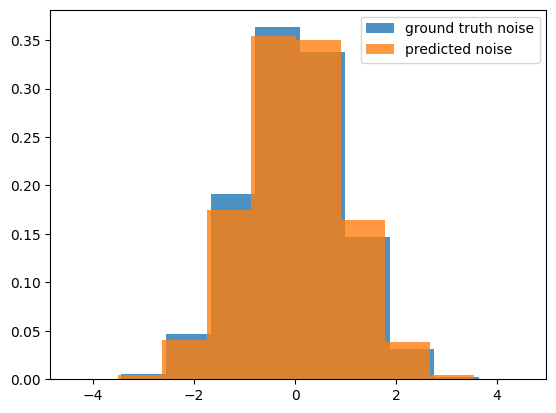

---
Epoch: 10 | Train Loss nan | Val Loss nan


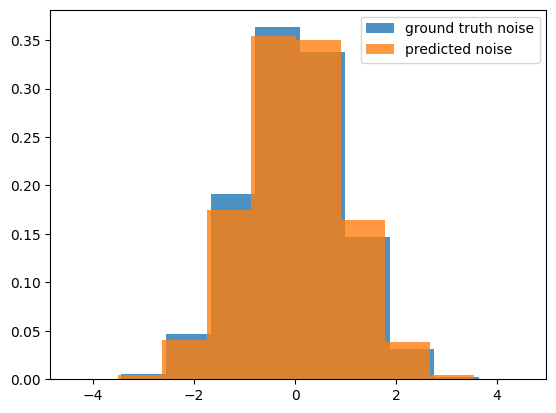

---
Epoch: 20 | Train Loss nan | Val Loss nan


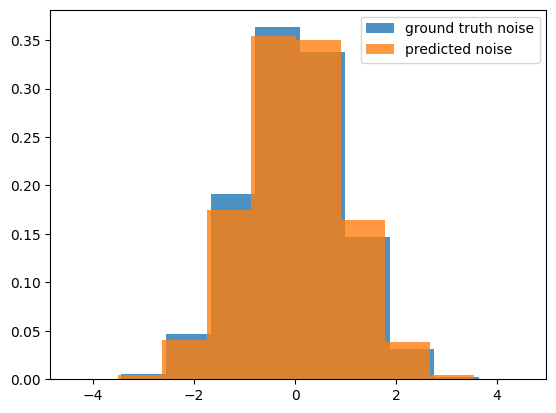

---
Epoch: 30 | Train Loss nan | Val Loss nan


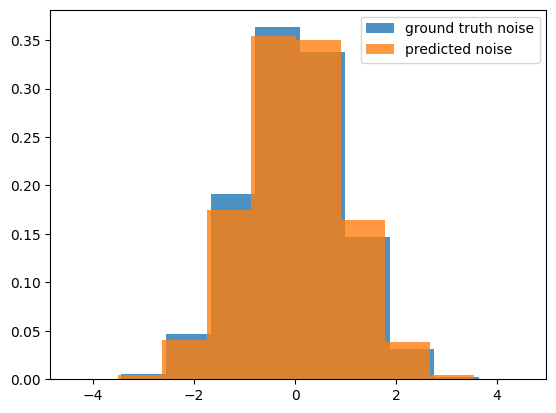

---
Epoch: 40 | Train Loss nan | Val Loss nan


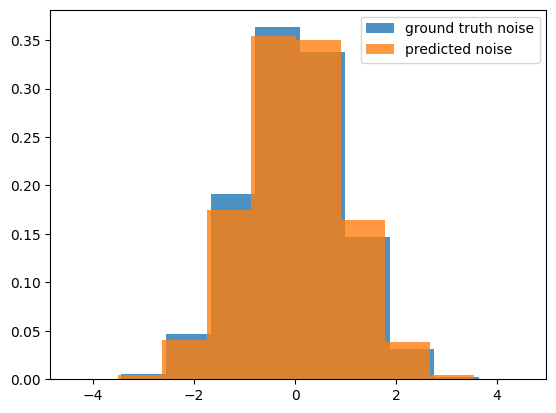

---
Epoch: 50 | Train Loss nan | Val Loss nan


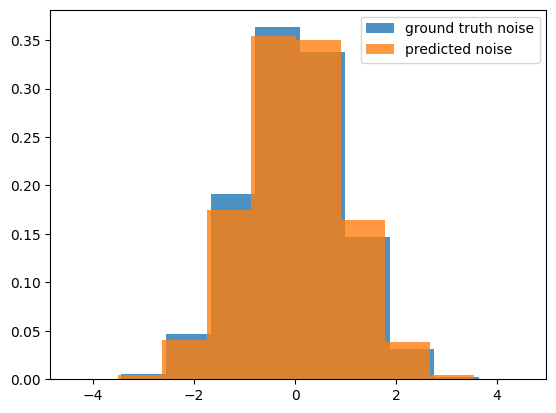

---
Epoch: 60 | Train Loss nan | Val Loss nan


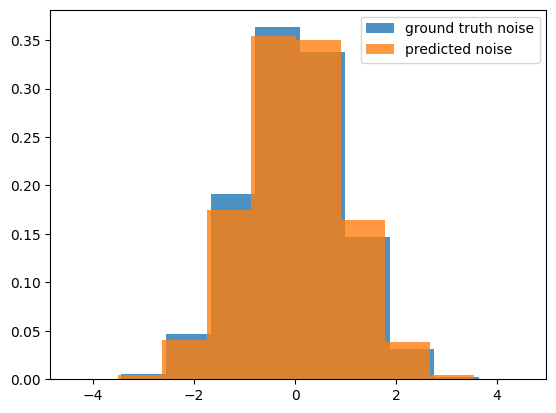

---
Epoch: 70 | Train Loss nan | Val Loss nan


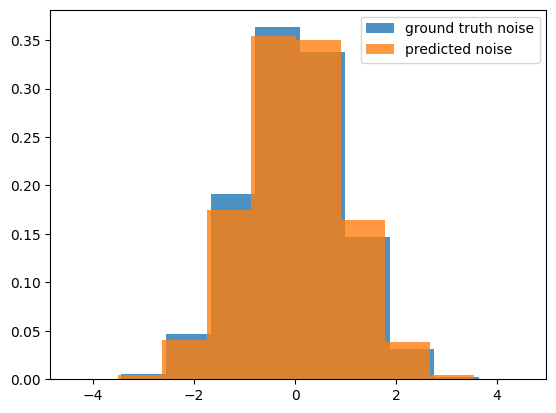

---
Epoch: 80 | Train Loss nan | Val Loss nan


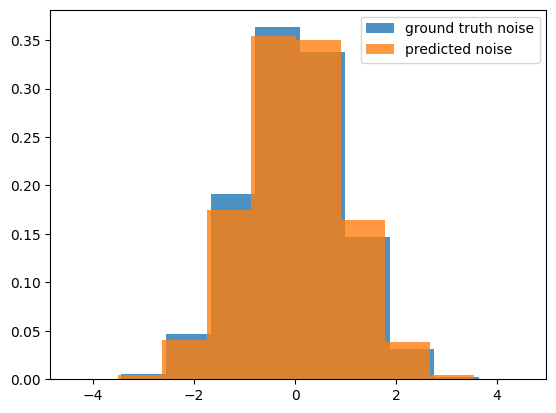

---
Epoch: 90 | Train Loss nan | Val Loss nan


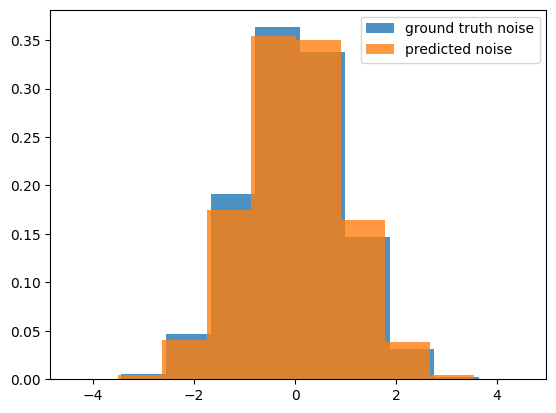

---
Epoch: 100 | Train Loss nan | Val Loss nan


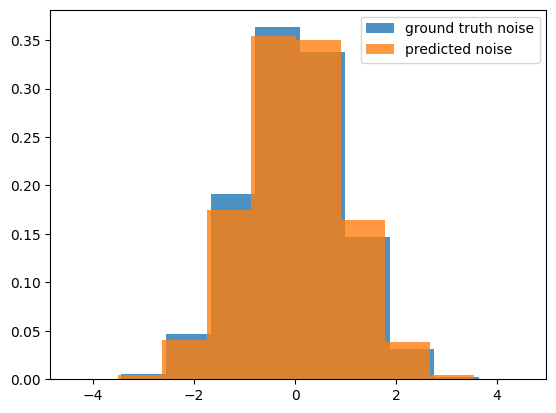

---
Epoch: 110 | Train Loss nan | Val Loss nan


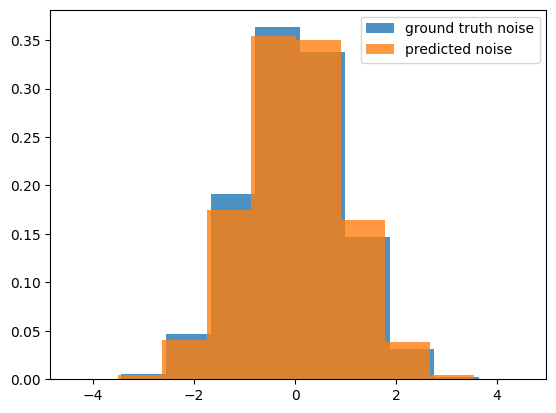

---
Epoch: 120 | Train Loss nan | Val Loss nan


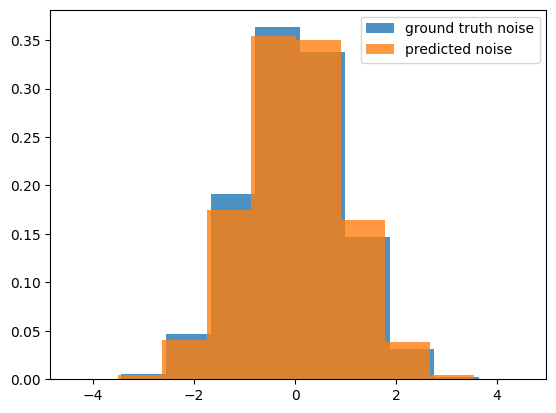

---
Epoch: 130 | Train Loss nan | Val Loss nan


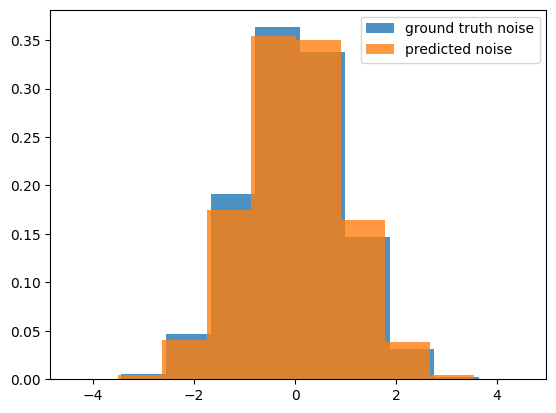

---
Epoch: 140 | Train Loss nan | Val Loss nan


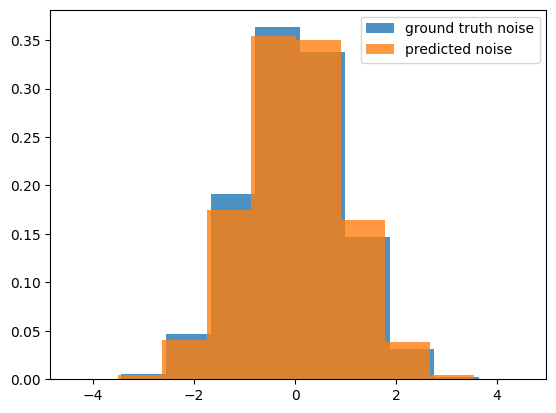

---
Epoch: 150 | Train Loss nan | Val Loss nan


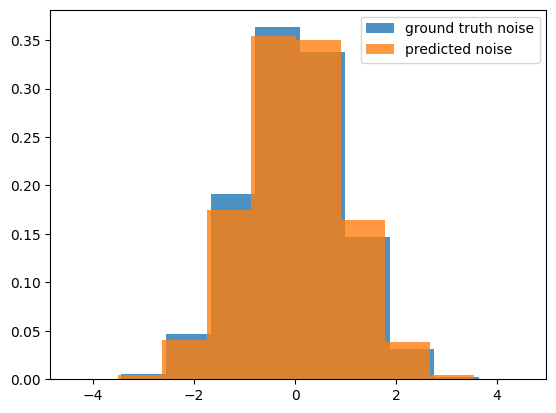

---
Epoch: 160 | Train Loss nan | Val Loss nan


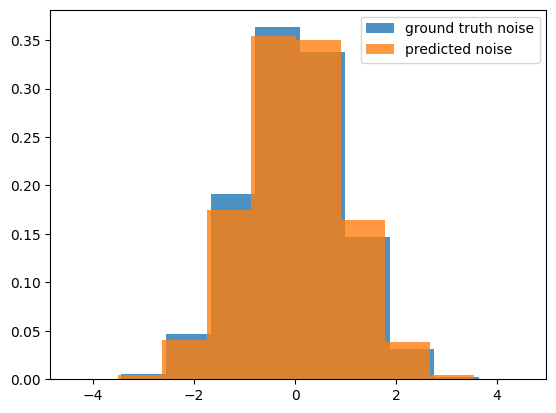

---
Epoch: 170 | Train Loss nan | Val Loss nan


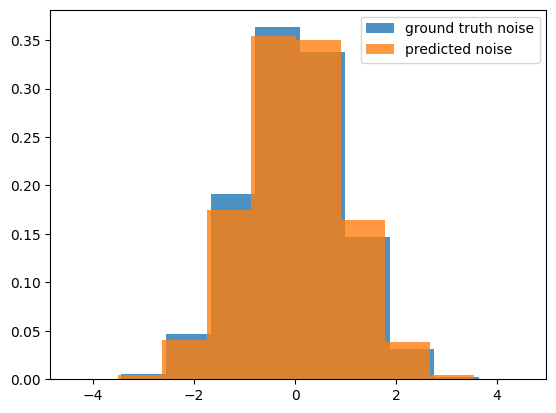

---
Epoch: 180 | Train Loss nan | Val Loss nan


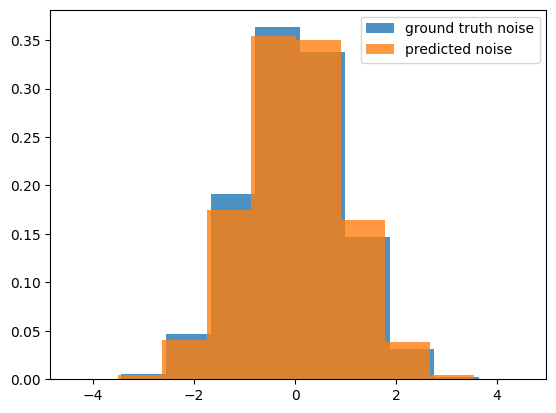

---
Epoch: 190 | Train Loss nan | Val Loss nan


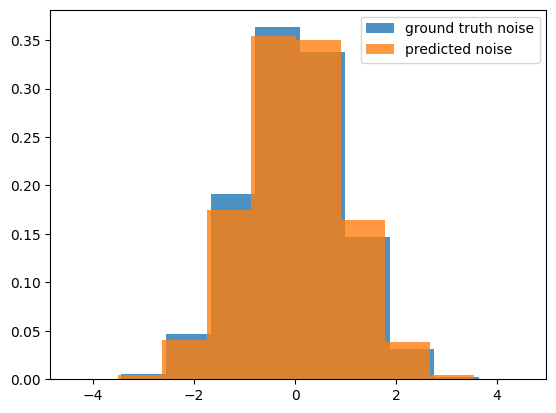

---
Epoch: 200 | Train Loss nan | Val Loss nan


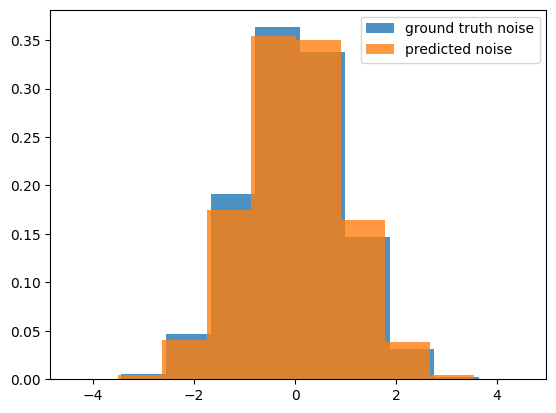

---
Epoch: 210 | Train Loss nan | Val Loss nan


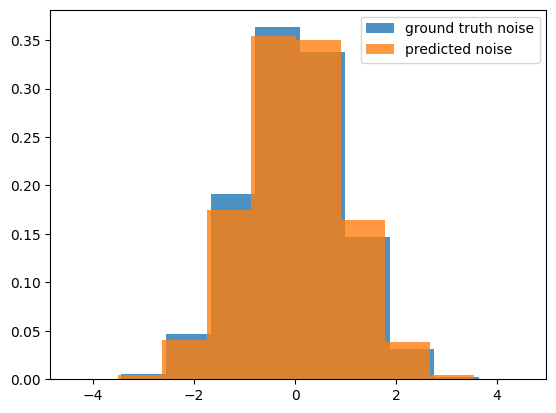

---
Epoch: 220 | Train Loss nan | Val Loss nan


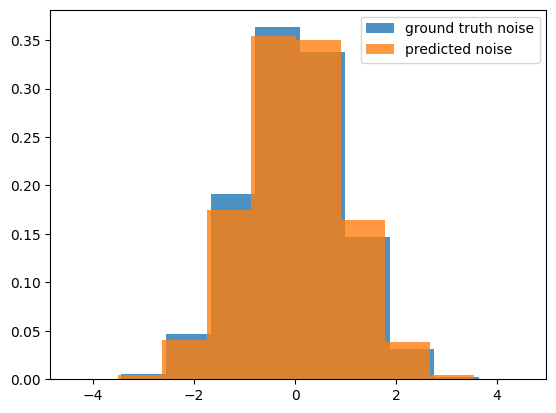

---
Epoch: 230 | Train Loss nan | Val Loss nan


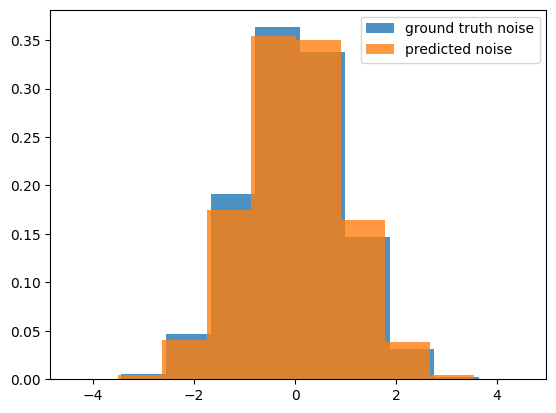

---
Epoch: 240 | Train Loss nan | Val Loss nan


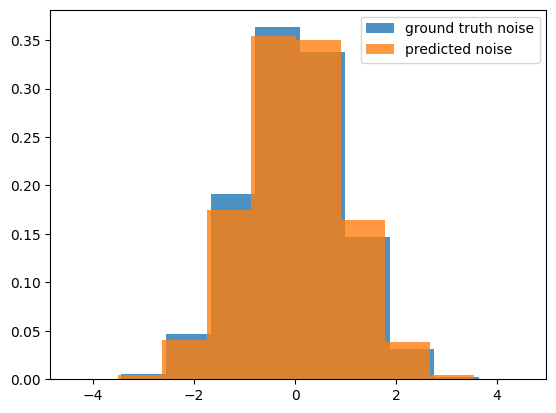

---
Epoch: 250 | Train Loss nan | Val Loss nan


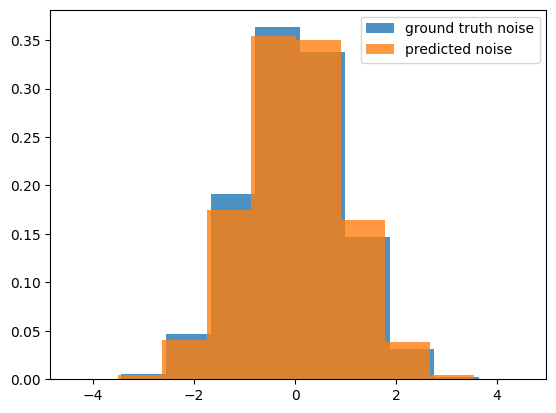

---
Epoch: 260 | Train Loss nan | Val Loss nan


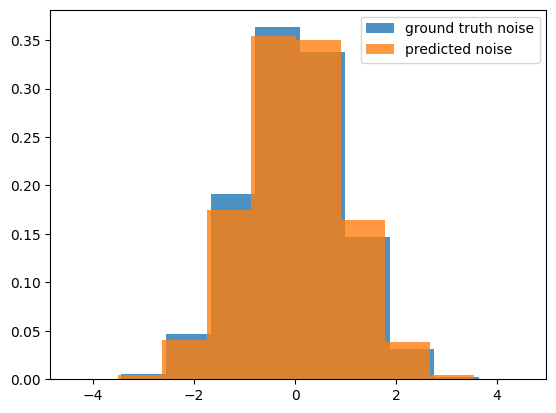

---
Epoch: 270 | Train Loss nan | Val Loss nan


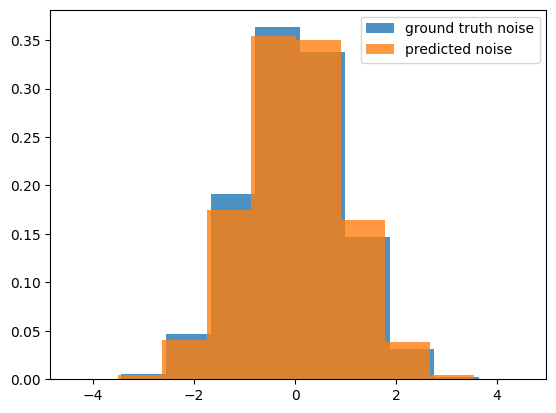

---
Epoch: 280 | Train Loss nan | Val Loss nan


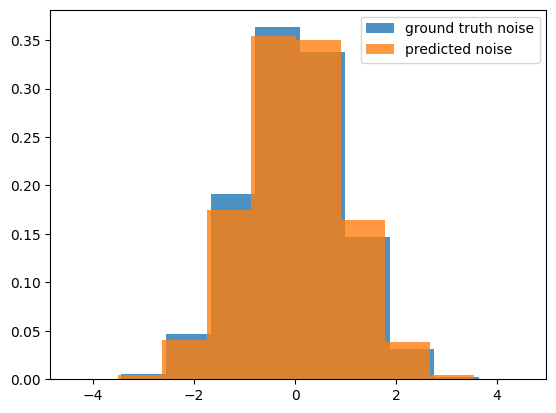

---
Epoch: 290 | Train Loss nan | Val Loss nan


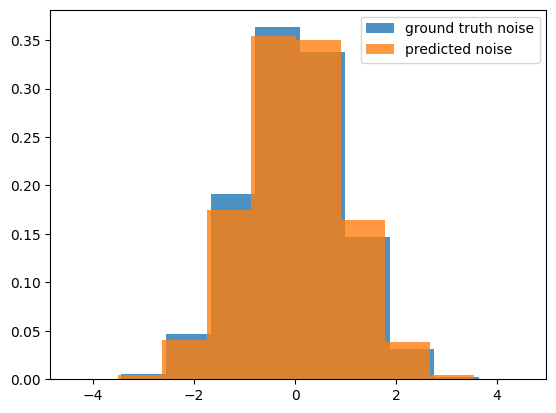

---
Epoch: 300 | Train Loss nan | Val Loss nan


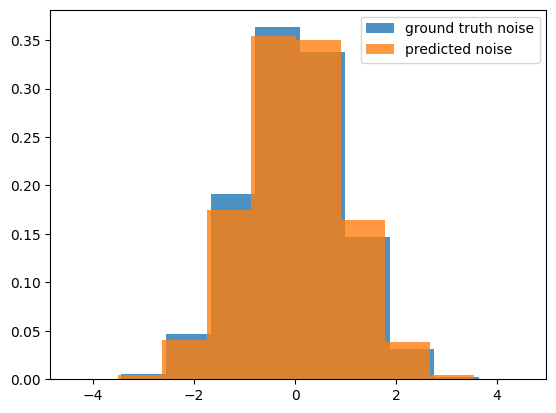

---
Epoch: 310 | Train Loss nan | Val Loss nan


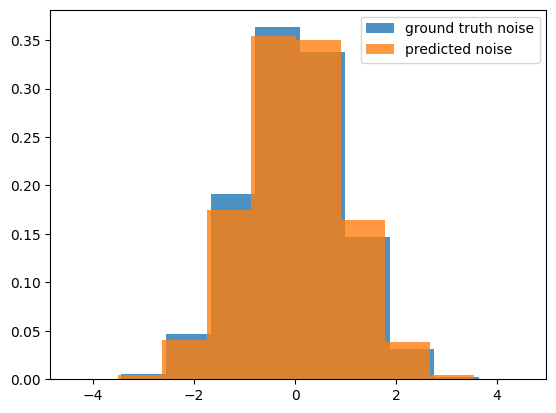

---
Epoch: 320 | Train Loss nan | Val Loss nan


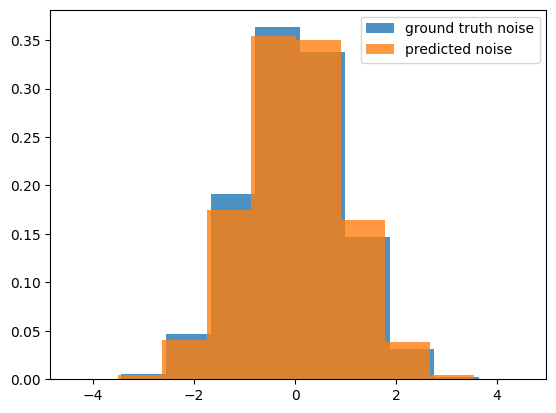

---
Epoch: 330 | Train Loss nan | Val Loss nan


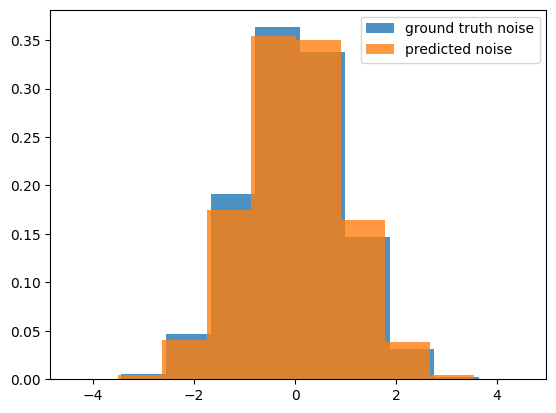

---
Epoch: 340 | Train Loss nan | Val Loss nan


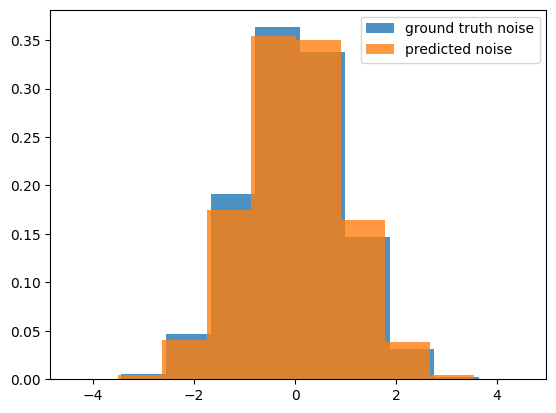

---
Epoch: 350 | Train Loss nan | Val Loss nan


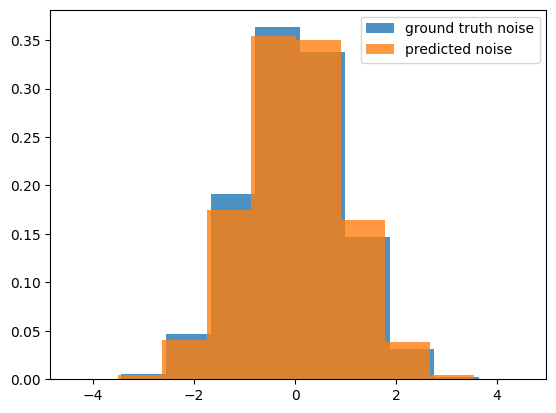

---
Epoch: 360 | Train Loss nan | Val Loss nan


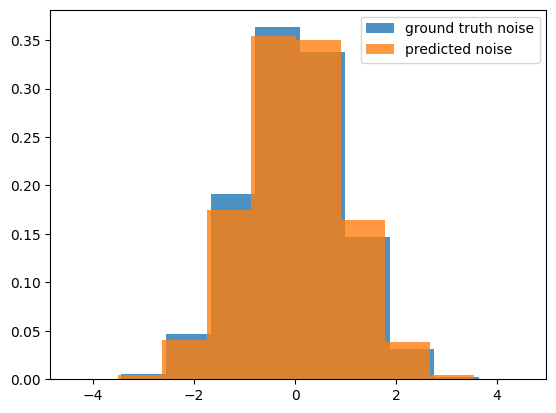

---
Epoch: 370 | Train Loss nan | Val Loss nan


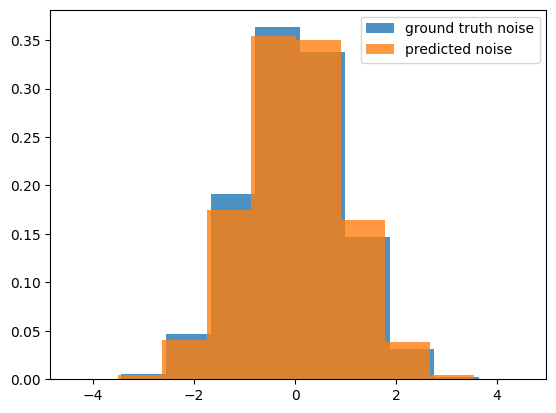

---
Epoch: 380 | Train Loss nan | Val Loss nan


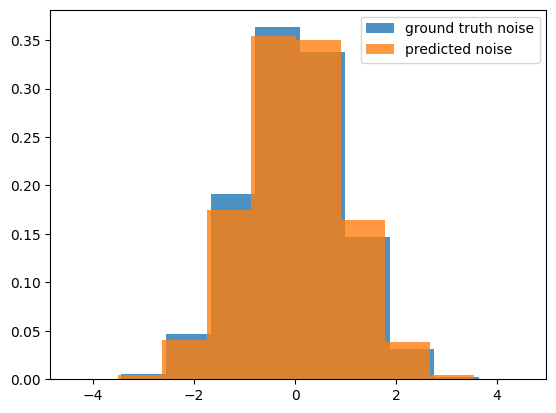

---
Epoch: 390 | Train Loss nan | Val Loss nan


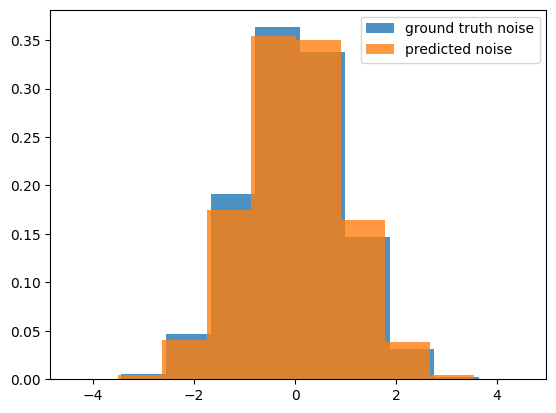

---
Epoch: 400 | Train Loss nan | Val Loss nan


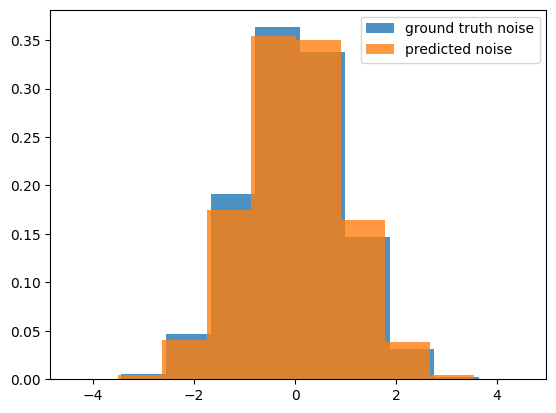

---
Epoch: 410 | Train Loss nan | Val Loss nan


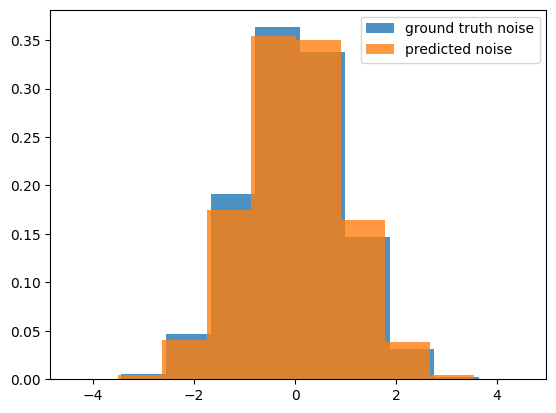

---
Epoch: 420 | Train Loss nan | Val Loss nan


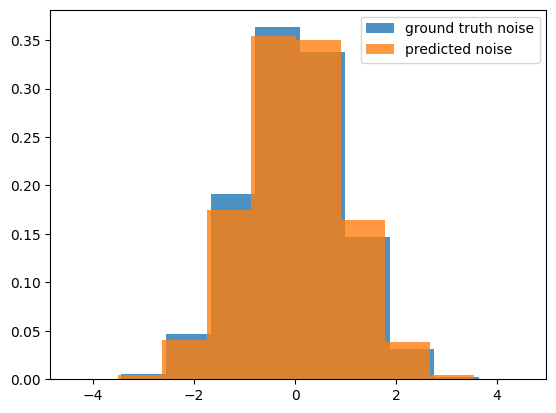

---
Epoch: 430 | Train Loss nan | Val Loss nan


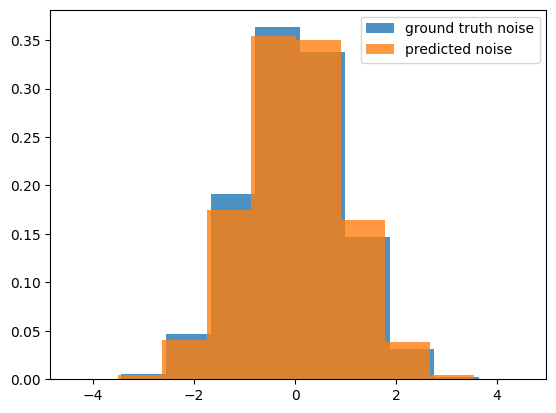

---
Epoch: 440 | Train Loss nan | Val Loss nan


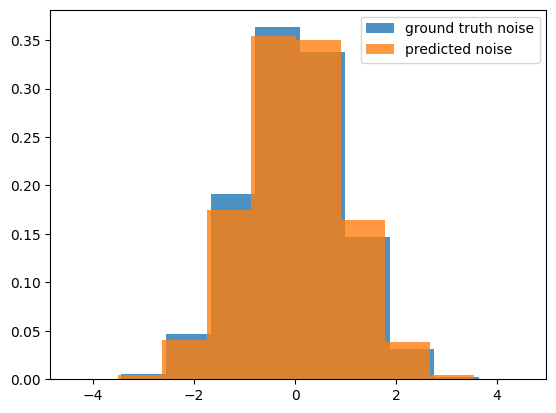

---
Epoch: 450 | Train Loss nan | Val Loss nan


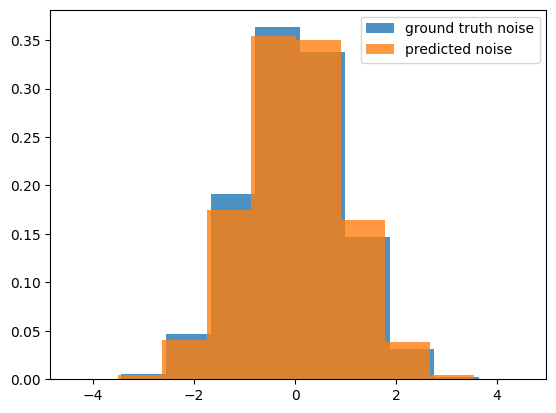

---
Epoch: 460 | Train Loss nan | Val Loss nan


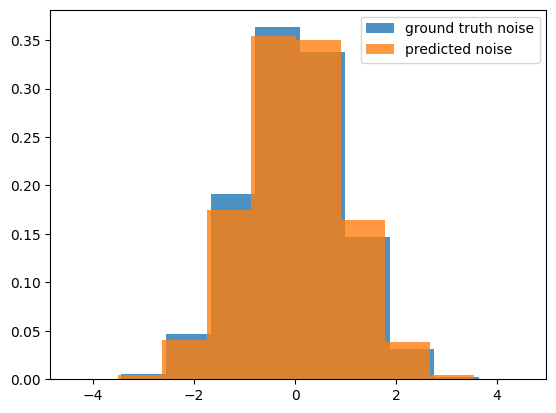

---
Epoch: 470 | Train Loss nan | Val Loss nan


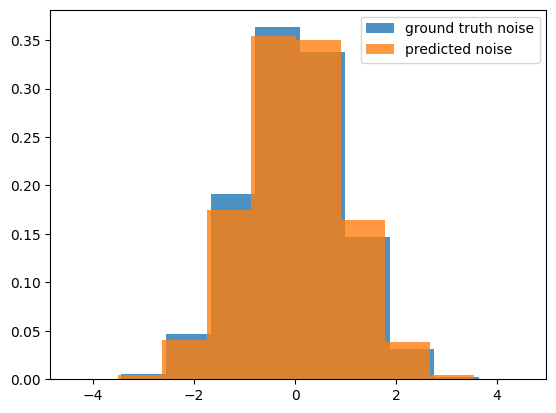

---
Epoch: 480 | Train Loss nan | Val Loss nan


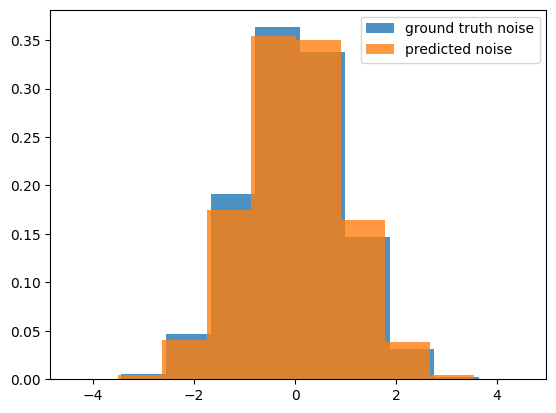

---
Epoch: 490 | Train Loss nan | Val Loss nan


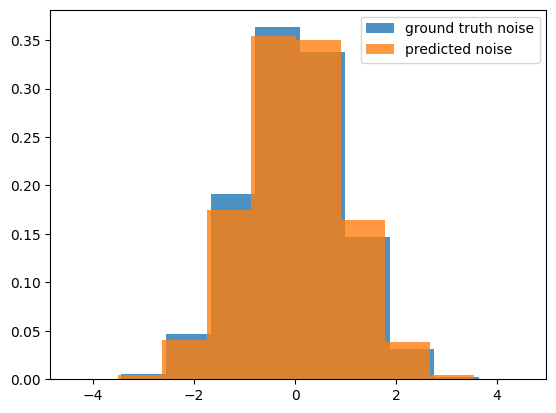

---
Epoch: 500 | Train Loss nan | Val Loss nan


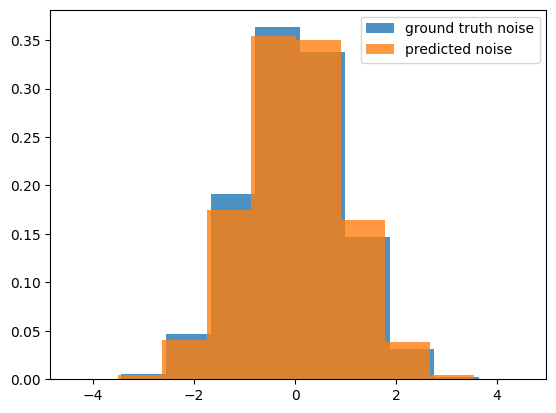

---
Epoch: 510 | Train Loss nan | Val Loss nan


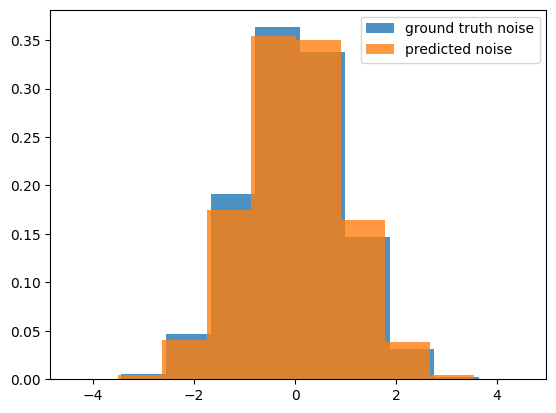

---
Epoch: 520 | Train Loss nan | Val Loss nan


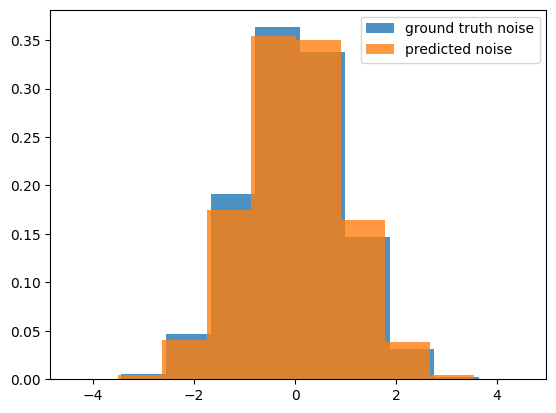

---
Epoch: 530 | Train Loss nan | Val Loss nan


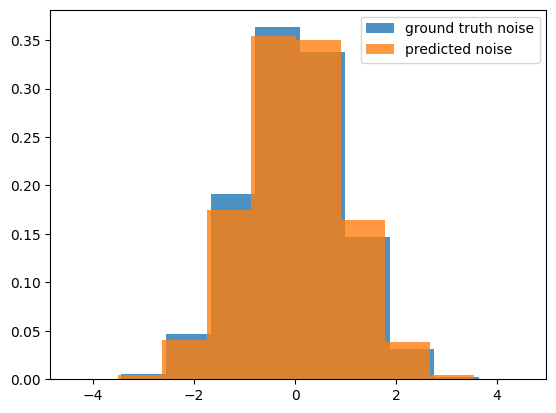

---
Epoch: 540 | Train Loss nan | Val Loss nan


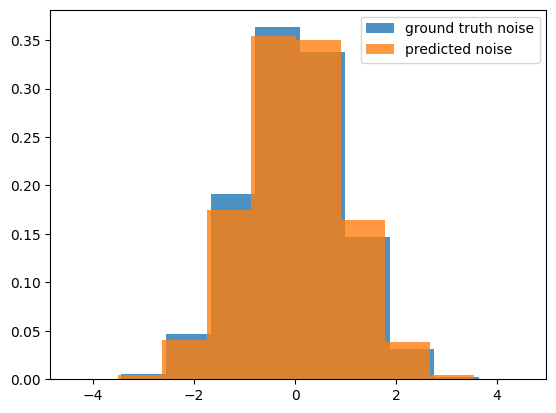

---
Epoch: 550 | Train Loss nan | Val Loss nan


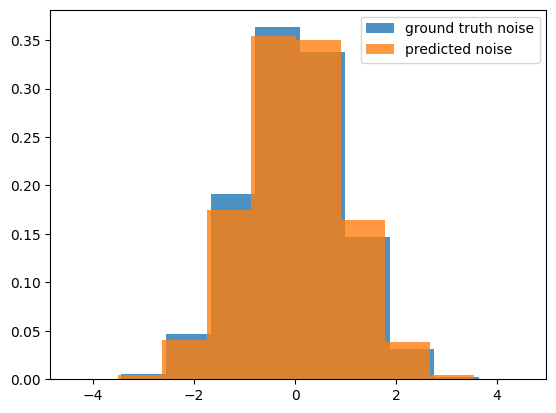

---
Epoch: 560 | Train Loss nan | Val Loss nan


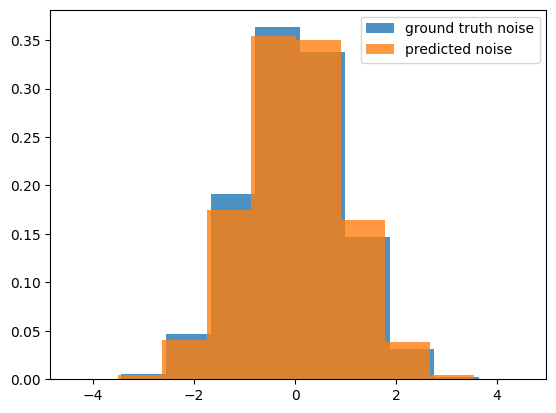

---
Epoch: 570 | Train Loss nan | Val Loss nan


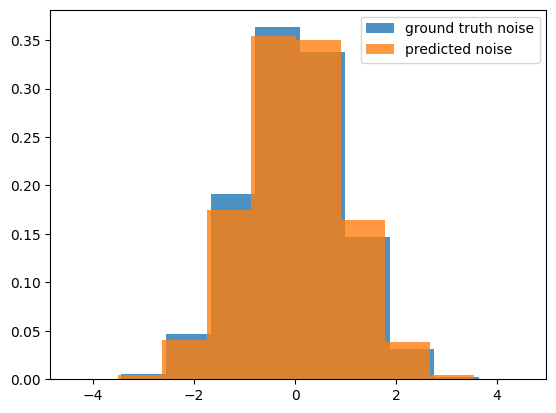

---
Epoch: 580 | Train Loss nan | Val Loss nan


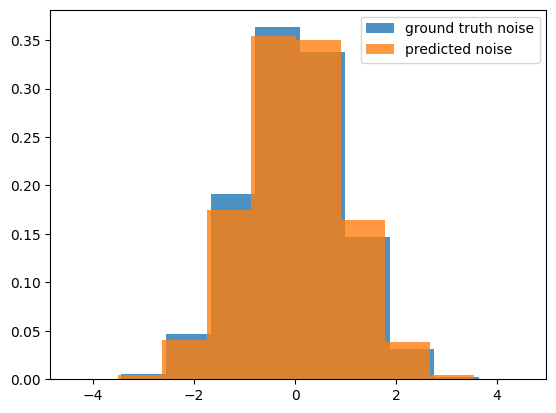

---
Epoch: 590 | Train Loss nan | Val Loss nan


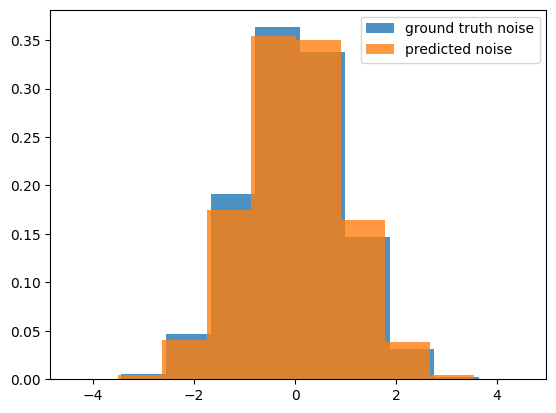

---
Epoch: 600 | Train Loss nan | Val Loss nan


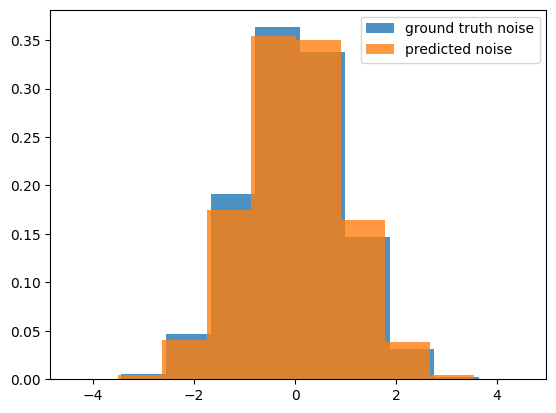

---
Epoch: 610 | Train Loss nan | Val Loss nan


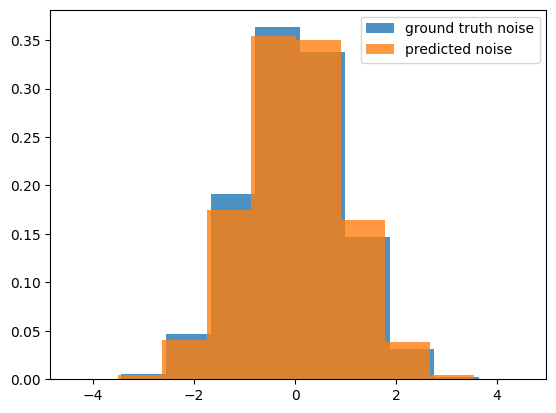

---
Epoch: 620 | Train Loss nan | Val Loss nan


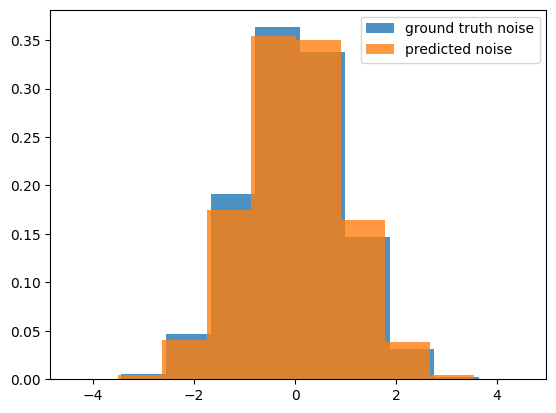

---
Epoch: 630 | Train Loss nan | Val Loss nan


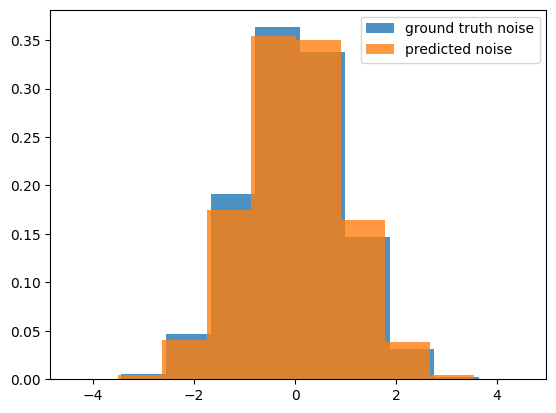

---
Epoch: 640 | Train Loss nan | Val Loss nan


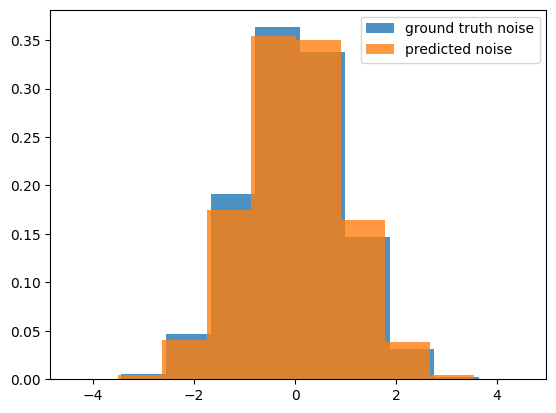

---
Epoch: 650 | Train Loss nan | Val Loss nan


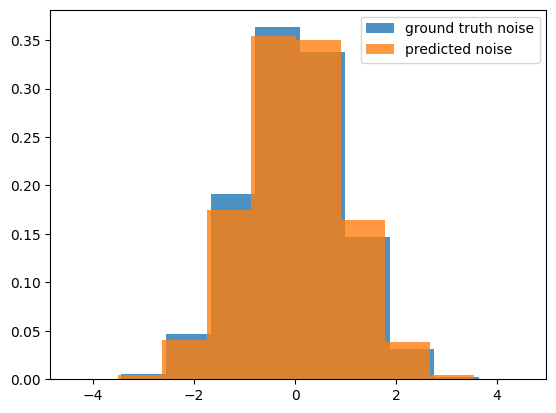

---
Epoch: 660 | Train Loss nan | Val Loss nan


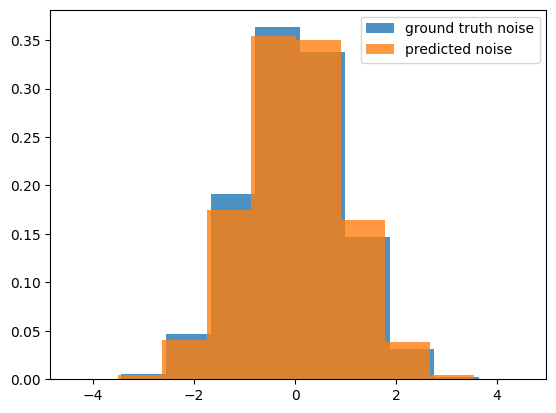

---
Epoch: 670 | Train Loss nan | Val Loss nan


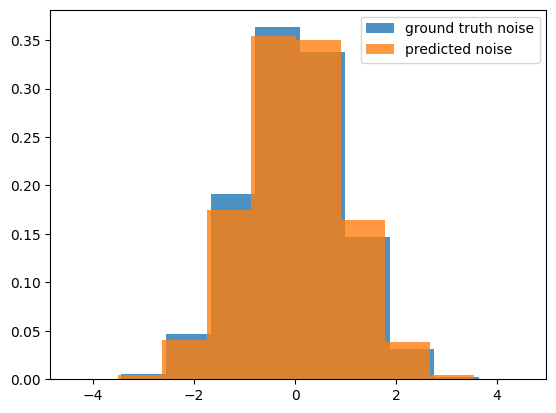

---
Epoch: 680 | Train Loss nan | Val Loss nan


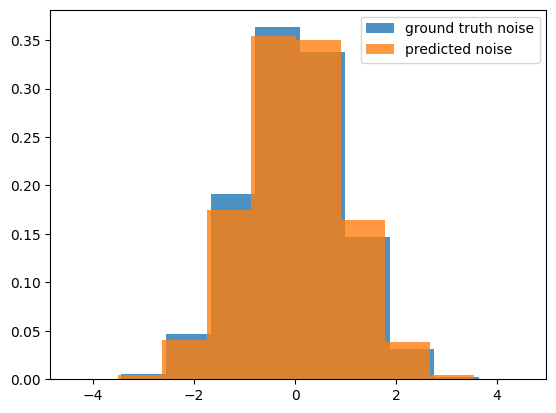

---
Epoch: 690 | Train Loss nan | Val Loss nan


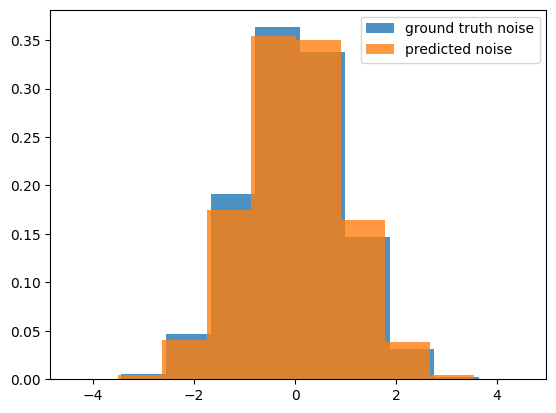

---
Epoch: 700 | Train Loss nan | Val Loss nan


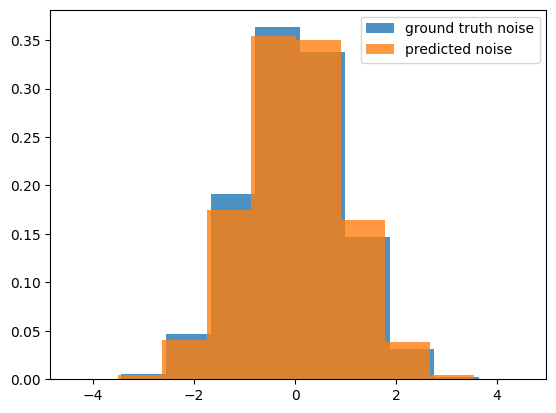

---
Epoch: 710 | Train Loss nan | Val Loss nan


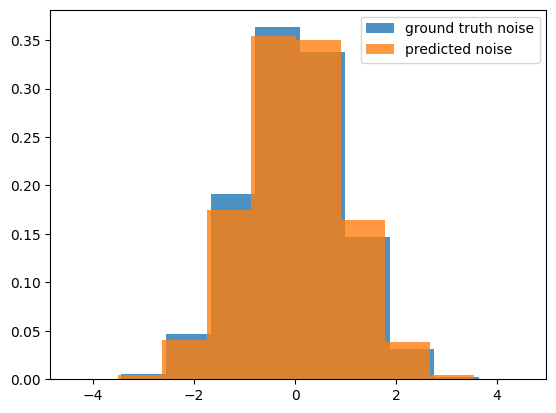

---
Epoch: 720 | Train Loss nan | Val Loss nan


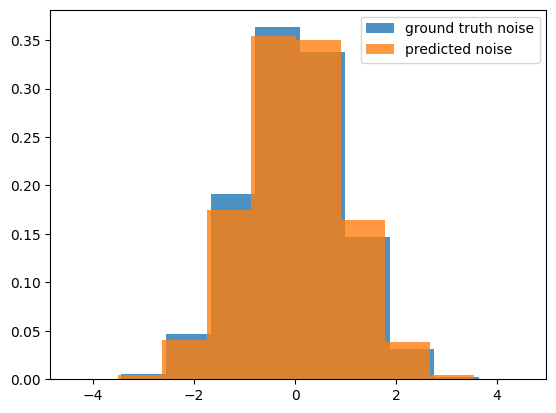

---
Epoch: 730 | Train Loss nan | Val Loss nan


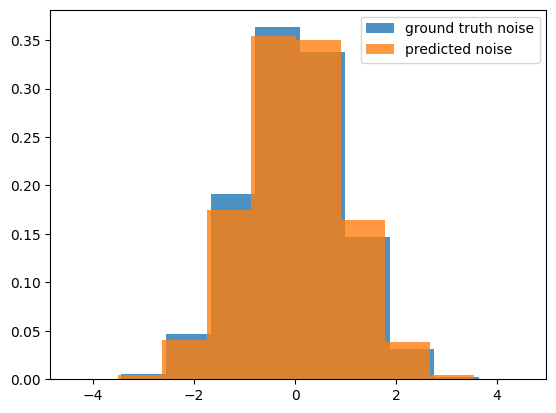

---
Epoch: 740 | Train Loss nan | Val Loss nan


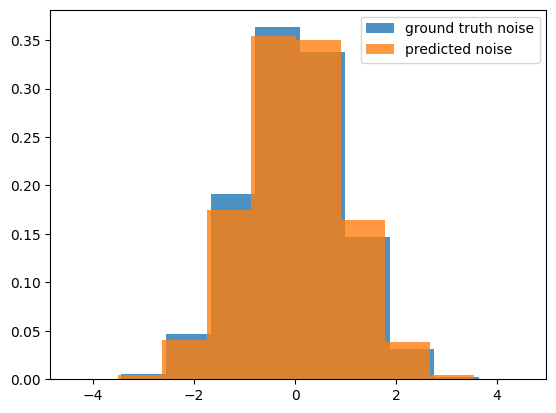

---
Epoch: 750 | Train Loss nan | Val Loss nan


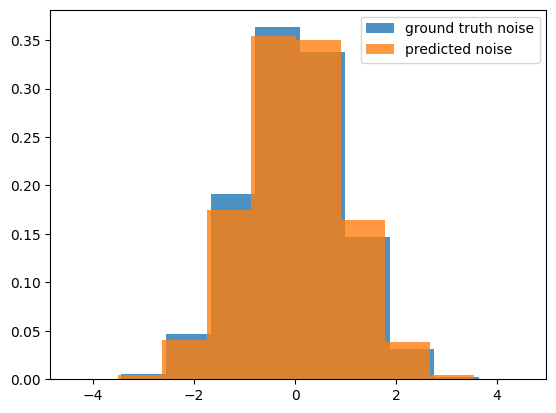

---
Epoch: 760 | Train Loss nan | Val Loss nan


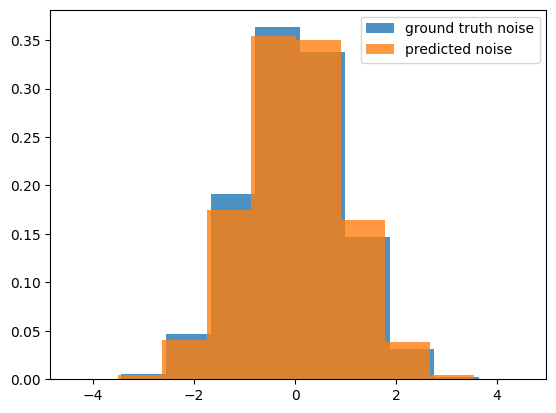

---
Epoch: 770 | Train Loss nan | Val Loss nan


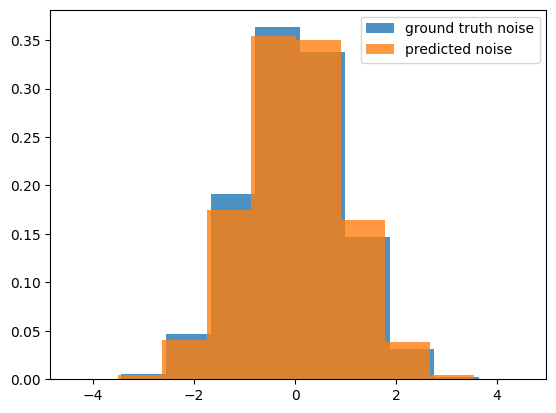

---
Epoch: 780 | Train Loss nan | Val Loss nan


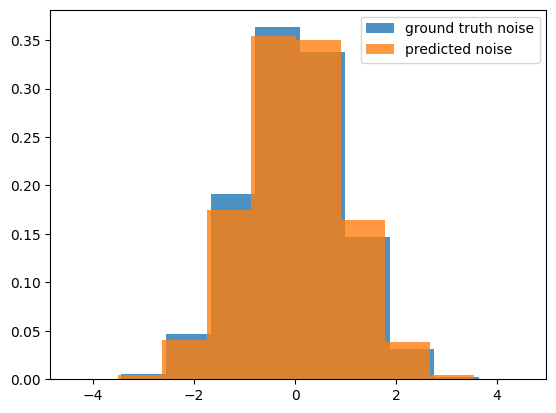

---
Epoch: 790 | Train Loss nan | Val Loss nan


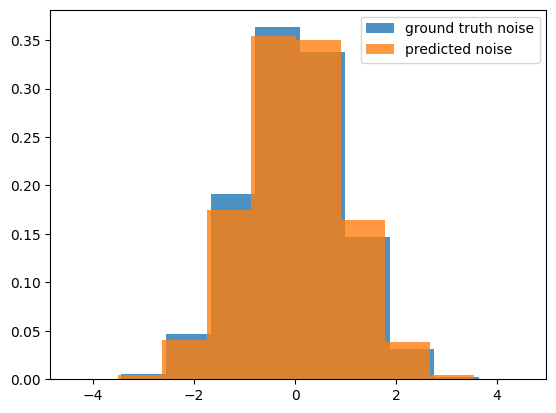

---
Epoch: 800 | Train Loss nan | Val Loss nan


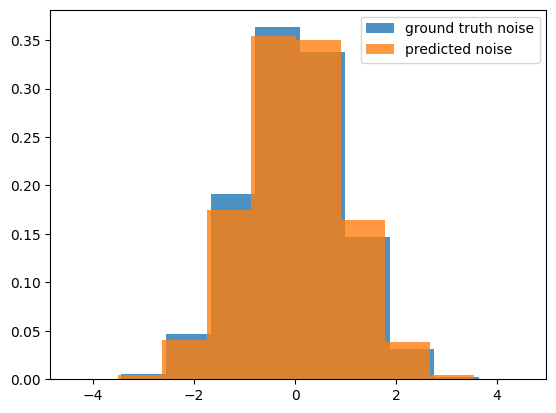

---
Epoch: 810 | Train Loss nan | Val Loss nan


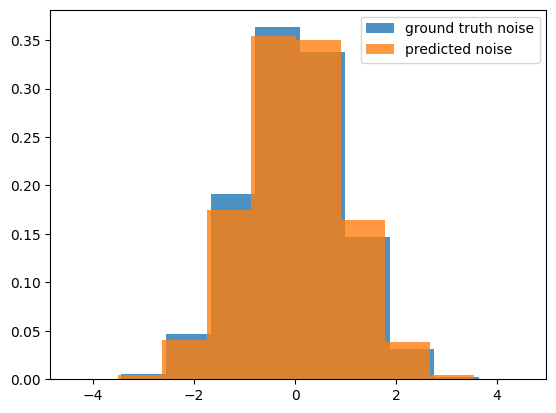

---
Epoch: 820 | Train Loss nan | Val Loss nan


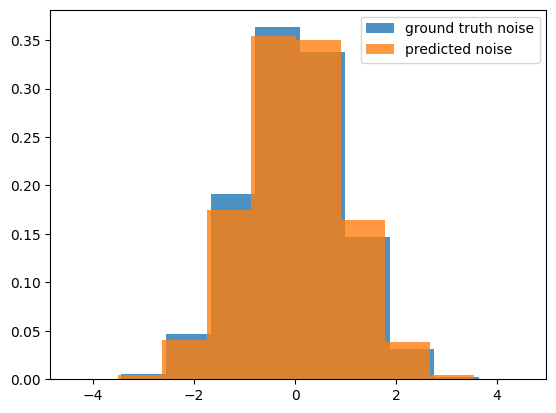

---
Epoch: 830 | Train Loss nan | Val Loss nan


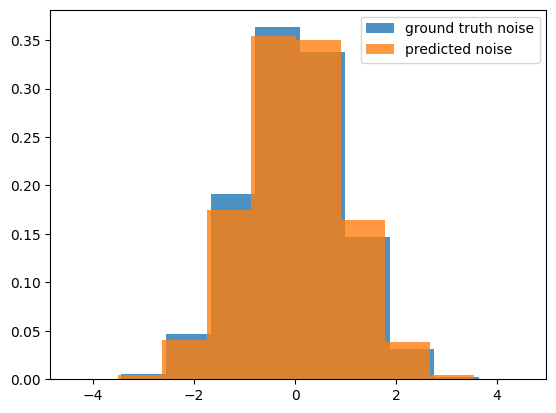

---
Epoch: 840 | Train Loss nan | Val Loss nan


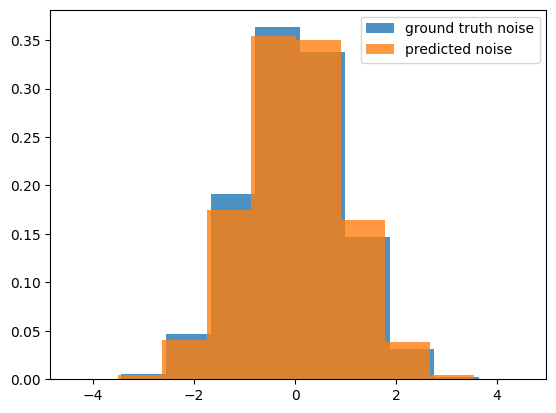

---
Epoch: 850 | Train Loss nan | Val Loss nan


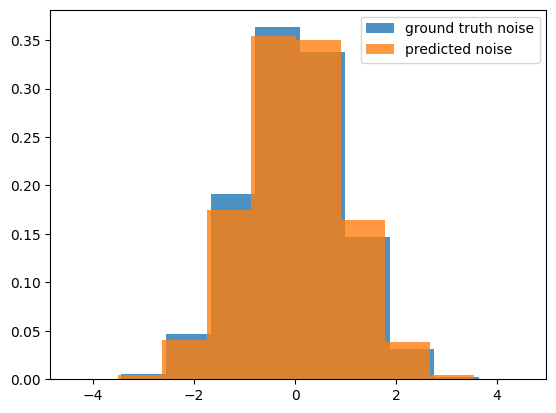

---
Epoch: 860 | Train Loss nan | Val Loss nan


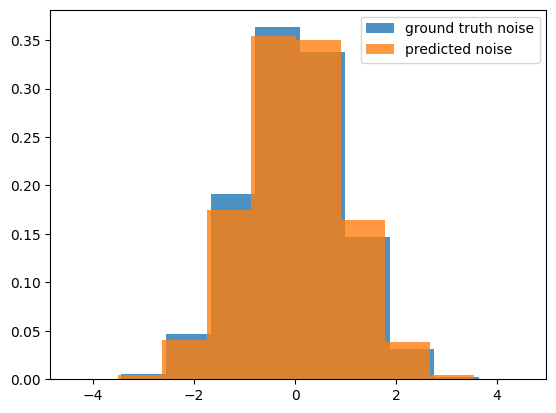

---
Epoch: 870 | Train Loss nan | Val Loss nan


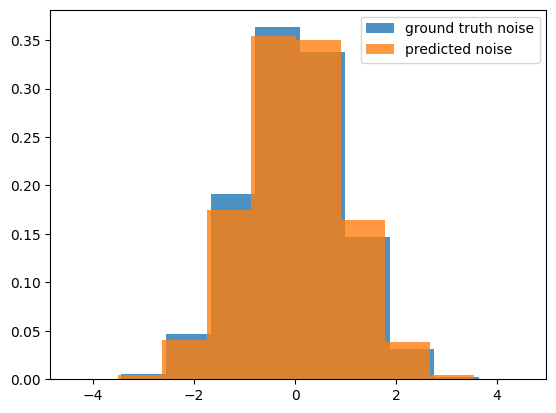

---
Epoch: 880 | Train Loss nan | Val Loss nan


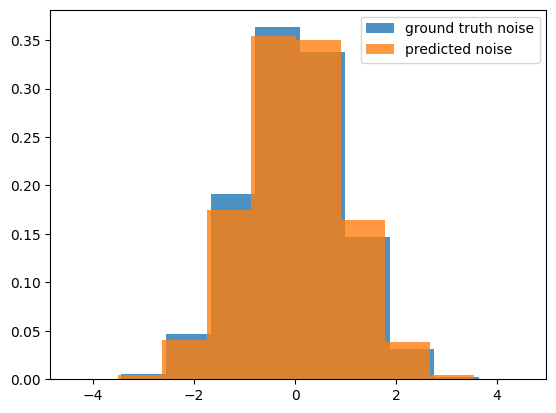

---
Epoch: 890 | Train Loss nan | Val Loss nan


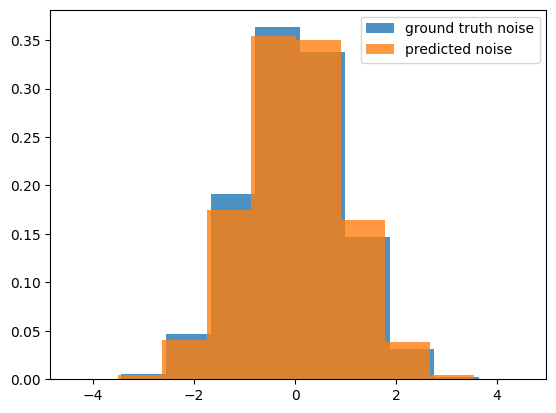

---
Epoch: 900 | Train Loss nan | Val Loss nan


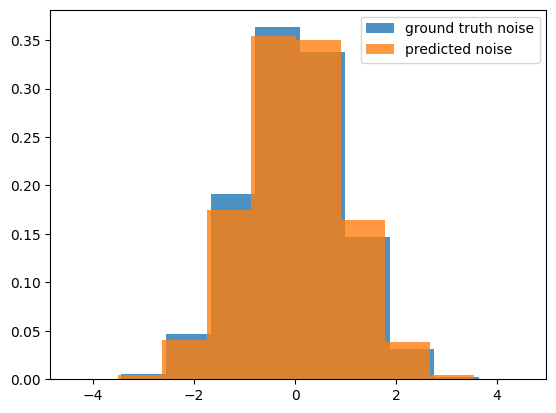

---
Epoch: 910 | Train Loss nan | Val Loss nan


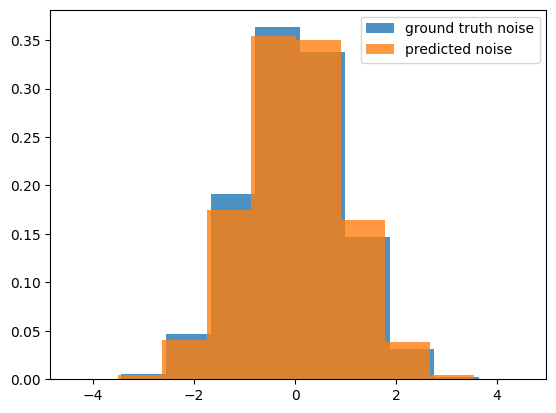

---
Epoch: 920 | Train Loss nan | Val Loss nan


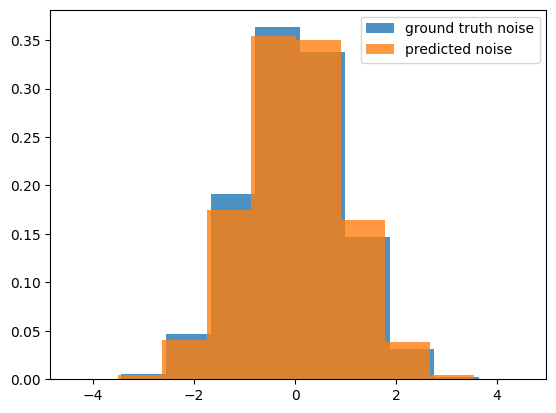

---
Epoch: 930 | Train Loss nan | Val Loss nan


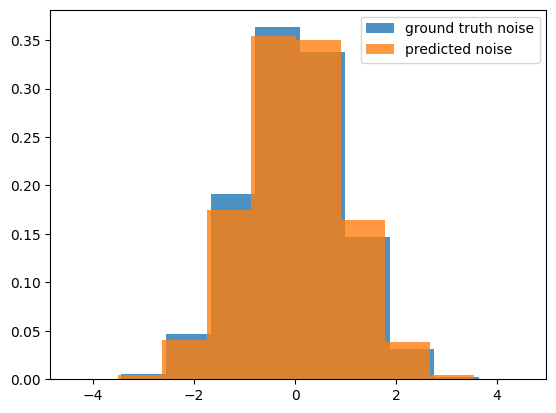

---
Epoch: 940 | Train Loss nan | Val Loss nan


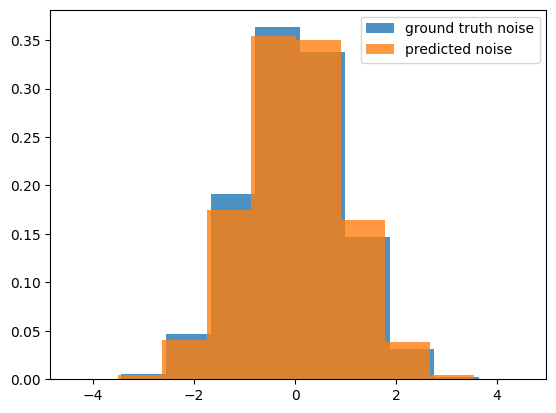

---
Epoch: 950 | Train Loss nan | Val Loss nan


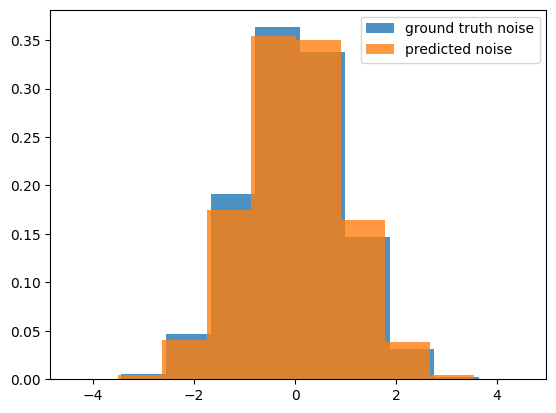

---
Epoch: 960 | Train Loss nan | Val Loss nan


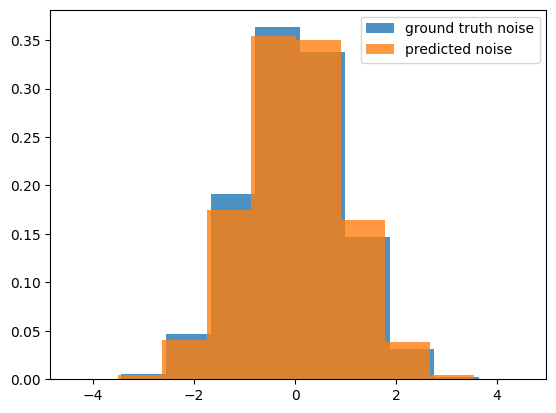

---
Epoch: 970 | Train Loss nan | Val Loss nan


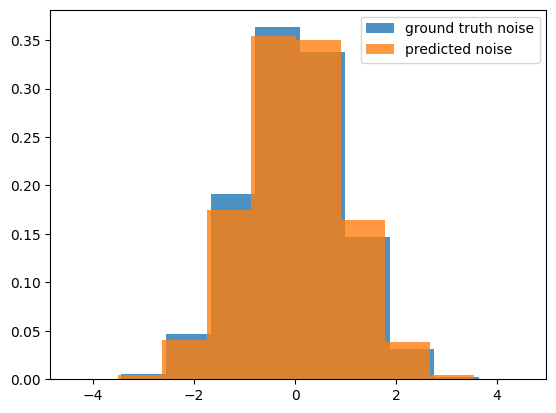

---
Epoch: 980 | Train Loss nan | Val Loss nan


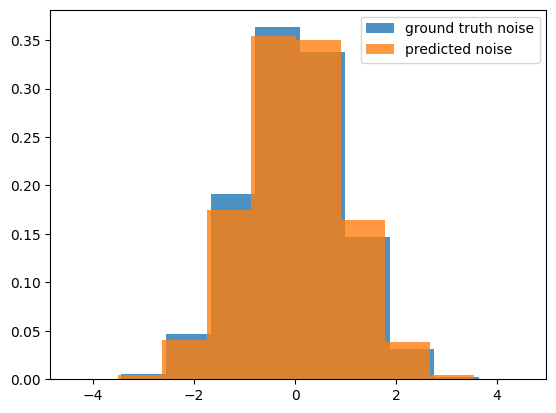

---
Epoch: 990 | Train Loss nan | Val Loss nan


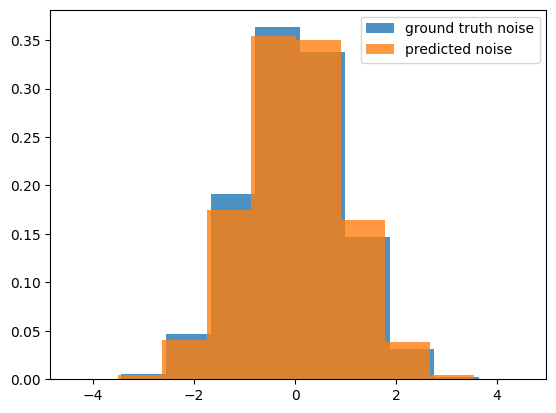

In [199]:
for epoch in range(NO_EPOCHS):

    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch in trainloader:

        batch = batch[0]

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        try:
          batch_noisy, noise = diffusion_model.forward(batch, t, device)
        except:
          continue
        z , z_mu, z_var = unet(batch_noisy, t)

        predicted_noise = z

        optimizer.zero_grad()
        kld = torch.mean(-0.5 * torch.sum(1 + z_var - z_mu ** 2 - z_var.exp(), dim = 1), dim = 0)
        loss = kld #kl_divergence(z , z_mu, z_var) #torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    for batch in testloader:

        batch = batch[0]

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        try:
          batch_noisy, noise = diffusion_model.forward(batch, t, device)
        except:
          continue
        z , z_mu, z_var = unet(batch_noisy, t)

        predicted_noise = z

        optimizer.zero_grad()
        kld = torch.mean(-0.5 * torch.sum(1 + z_var - z_mu ** 2 - z_var.exp(), dim = 1), dim = 0)
        loss = kld #kl_divergence(z , z_mu, z_var) #torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_distribution(noise, predicted_noise)

        torch.save(unet.state_dict(), f"epoch: {epoch}")

In [170]:
diffusion_model.timesteps

500

In [200]:
with torch.no_grad():
    img = torch.randn(708).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            print('i',i)
            print(img)

i 450
tensor([[ 6.4965e-01,  3.2942e+00, -2.9404e+00, -3.9722e+00, -2.5600e+00,
          2.9662e+00,  2.3073e+00,  1.4534e+00,  3.7763e+00,  3.3676e+00,
          3.7735e-02,  3.8862e+00,  1.3477e+00,  4.7751e+00,  9.6244e-01,
         -1.0610e+00, -8.5349e-01, -8.2170e-01, -4.3014e+00, -5.1897e-01,
         -3.9681e+00, -3.1676e+00,  1.7725e+00, -2.7056e-01,  2.0672e+00,
         -4.7842e-01,  2.8986e-01, -3.7837e-01, -1.2417e+00,  1.8385e+00,
         -5.8537e+00, -1.1803e-01, -1.5855e+00,  1.5125e+00,  7.5209e-01,
         -2.1895e+00, -1.9924e+00,  6.4361e-01, -3.7788e-01, -1.5049e+00,
         -5.6029e-01, -4.7359e-01,  1.1623e+00,  3.7318e+00,  5.5909e+00,
         -2.7197e+00,  3.2761e+00,  4.3523e+00,  2.8539e+00,  8.4676e-01,
          2.4944e-01, -1.3764e+00, -4.9036e-01, -5.5152e+00, -2.1279e+00,
          1.7775e+00, -1.3681e+00,  2.9470e+00,  1.1944e+00,  6.3666e-01,
         -3.5050e+00, -2.9146e+00, -1.0196e+00,  1.7889e+00, -3.1529e+00,
         -7.0077e-02, -7.0255e-0

In [ ]:
import ase
import yaml
import time
import copy
import joblib
import pickle
import numpy as np
import datetime
from ase import Atoms, io, build

data_list = []
n_samples = 20

i = 1
m = 0

print('a')

while len(data_list) < n_samples :

    rev_x = 0
    rev_x_need_scaling, composition_vec = rev_x[:, :708-101], rev_x[:,-101:]

    rev_x_scaled = scaler.inverse_transform(rev_x_need_scaling.cpu().data.numpy())
    rev_x_scaled = torch.tensor(rev_x_scaled, dtype=torch.float, device='cpu')

    tota_atm = torch.round(composition_vec[:,100])
    composition_vec = composition_vec[:,0:100]

    top_values, top_indices = composition_vec.topk(6)
    new_tensor2 = torch.zeros_like(composition_vec)
    new_tensor2[0][top_indices] = top_values

    composition_vec = (torch.round(new_tensor2[0]))
    composition_vec[composition_vec < 0] = 0 # May change this value.
    sum_comp = torch.sum(composition_vec[0])

    atomic_vec = torch.round((composition_vec/5) * tota_atm).int()
    atomic_vec = atomic_vec.flatten()


    if torch.sum(atomic_vec) == 0:# or (torch.any(cell > 3)):
      continue

    atomic_numbers = []

    # find atomic number of all the elements with non-zero compostions.

    # atomic number will be as a tensor.
    for j in range(100):
        atomic_numbers.append(atomic_vec[j]*[str(j+1)])

    # make list of lists. [[] , [] , []]
    atomic_numbers = [item for sublist in atomic_numbers for item in sublist]

    if len(atomic_numbers)!=5: # or (tota_atm<5):
      continue


    cell = rev_x_scaled[0, 601:607]

    print("cell1: ", cell)  # cell1:  tensor([3.8627, 4.6770, 6.7244, 1.5247, 1.7004, 1.5864])
    cell[3:6] = cell[3:6] * 180 / np.pi
    print("cell2: ", cell)  #cell2:  tensor([ 3.8627,  4.6770,  6.7244, 87.3581, 97.4244, 90.8916])

    print("========= ", i)
    print('dist',rev_x_scaled[0][600])
    print('composition_vec',composition_vec)
    print('atomic_vec',atomic_vec)
    print('tot_atm', tota_atm)
    print('atomic_num', atomic_numbers)
    print("cell1: ", cell)

    placeholder = Atoms(numbers=[1], positions=[[0,0,0]], cell=cell.detach().cpu().numpy())
    cell = placeholder.get_cell()

    # fianl data dictionary
    data = {}
    data['positions'] = []
    data['atomic_numbers'] = np.array(atomic_numbers, dtype="int")
    data['cell'] = torch.tensor(np.array(cell), dtype=torch.float, device='cpu')
    data['representation'] = torch.unsqueeze(rev_x_scaled[0,:708-101-6], 0).detach()


    i+=1
    data_list.append(data)
    print('done')

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [ ]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()